In [1]:
import os
import itertools
from functools import reduce

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

import numpy
import pandas
import seaborn

from lab_v2.io import read_file

In [2]:
# FILE PATHS
DRAW_T03 = './data/draw/draw-T0.3.jsonl' 
CSQA_T07 = './data/csqa/csqa-T0.7.jsonl' 

ATTRIBUTES = ["majority_distance", "majority_distance_squared", "shannon_entropy", "gini_impurity"]
CLASS = 'majority_correct'

FILE_PATH = CSQA_T07

In [3]:
data = read_file(FILE_PATH)
data.head(1)

,majority_distance,majority_distance_squared,shannon_entropy,gini_impurity,majority_correct
0,1.378000e-07,0.0,0.0,0.0,True


## **Data exploration**

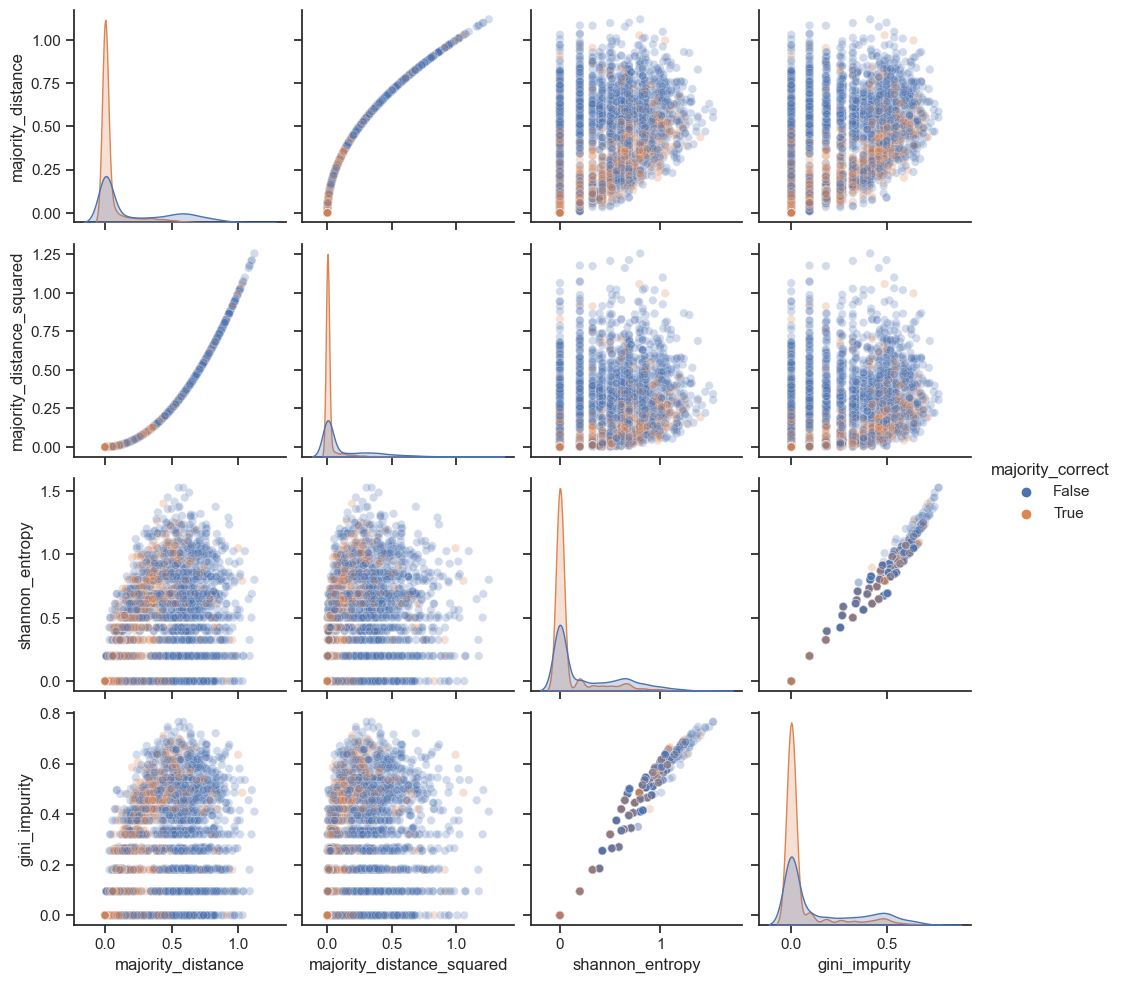

In [4]:
seaborn.set_theme(style='ticks')
seaborn.pairplot(data, hue="majority_correct", plot_kws={'alpha': 0.25})
print('')

In [5]:
data_x = data[ATTRIBUTES]
data_y = data[CLASS]

In [6]:
classification_reports = []
def classification_report_scorer(y_true, y_pred):
    classification_reports.append(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

In [7]:
def report_average(*args):
    report_list = list()
    for report in args:
        splited = [' '.join(x.split()) for x in report.split('\n\n')]
        header = [x for x in splited[0].split(' ')]
        data = numpy.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
        data = numpy.delete(data, 0, 1).astype(float)
        rest = splited[2].split(' ')
        accuarcy =numpy.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
        macro_avg = numpy.array([rest[5:9]]).astype(float).reshape(-1, len(header))
        weighted_avg = numpy.array([rest[11:]]).astype(float).reshape(-1, len(header))
        #avg_total = numpy.array([x for x in avg]).astype(float).reshape(-1, len(header))
        df = pandas.DataFrame(numpy.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
        report_list.append(df)
    res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
    return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})

In [8]:
class ReportAverage:
    def __init__(self):
        self.classification_reports = []

    def classification_report_scorer(self, y_true, y_pred):
        self.classification_reports.append(classification_report(y_true, y_pred))
        return accuracy_score(y_true, y_pred)
    
    def average_report(self):
        average = report_average(*self.classification_reports)
        return {
            'precision_True': average.loc[0]['precision'],
            'recall_True': average.loc[0]['recall'],
            'f1-score_True': average.loc[0]['f1-score'],
            'precision_False': average.loc[1]['precision'],
            'recall_False': average.loc[1]['recall'],
            'f1-score_False': average.loc[1]['f1-score'],
            'accuracy': average.loc['accuracy']['f1-score']
        }

In [9]:
scorer = ReportAverage()
cross_validate(RandomForestClassifier(), data_x, data_y, scoring=make_scorer(scorer.classification_report_scorer))
scorer.average_report().values()

dict_values([0.718, 0.386, 0.502, 0.644, 0.882, 0.744, 0.6620000000000001])

In [10]:
class MLExploration:
    TEMPLATE_DICT = {
        'model': '', 
        'hyperparameters': '', 
        'precision_True': '', 
        'recall_True': '', 
        'f1_True': '', 
        'precision_False': '', 
        'recall_False': '', 
        'f1_False': '', 
        'accuracy': ''
    }
    RANDOM_STATE = 42

    def __init__(self, data_x, data_y, output_file_path):
        self.data_x = data_x
        self.data_y = data_y
        self.output_file_path = output_file_path
        self.explored_models = pandas.DataFrame([MLExploration.TEMPLATE_DICT])
        if os.path.exists(output_file_path): 
            self.explored_models = pandas.read_json(output_file_path, orient='split')

    def grid_search(self, model, parameters):
        parameter_combinations = self.__parameter_product(parameters)
        for combination in parameter_combinations:
            print(combination)
            self.explore_model(model, combination)

    def explore_model(self, model, hyperparameters):
        index = MLExploration.hash(model, hyperparameters)
        if index in self.explored_models.index: return self.explored_models.loc[index]

        scorer = ReportAverage()
        cross_validate(model(**hyperparameters), data_x, data_y, scoring=make_scorer(scorer.classification_report_scorer))

        self.explored_models.loc[index] = [
            MLExploration.hash_model(model), 
            MLExploration.hash_hyperparameters(hyperparameters),
            *scorer.average_report().values()
        ]
        self.explored_models.to_json(self.output_file_path, orient='split')

    def hash_model(model):
        return str(model.__name__)
    
    def hash_hyperparameters(hyperparameters):
       return str(sorted(hyperparameters.items(), key=lambda x:x[0]))
    
    def hash(model, hyperparameters):
        model = MLExploration.hash_model(model)
        hyperparameters = MLExploration.hash_hyperparameters(hyperparameters)
        return str((model, hyperparameters))
    
    def __parameter_product(self, parameters):
        keys, values = zip(*parameters.items())
        experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
        return experiments

In [11]:
csqa = MLExploration(data_x, data_y, 'cache/csqa/csqa-T0.3.json')

In [15]:
csqa.explore_model(RandomForestClassifier, {})
csqa.explore_model(GaussianNB, {})
# csqa.grid_search(RandomForestClassifier, {
#     'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
# )
csqa.explored_models.style.hide(axis='index')

model,hyperparameters,precision_True,recall_True,f1_True,precision_False,recall_False,f1_False,accuracy
,,,,,,,,
RandomForestClassifier,{},0.720000,0.386000,0.504000,0.644000,0.880000,0.744000,0.664000
GaussianNB,{},0.750000,0.386000,0.510000,0.650000,0.898000,0.752000,0.672000
RandomForestClassifier,,0.718000,0.386000,0.504000,0.646000,0.878000,0.744000,0.662000
GaussianNB,,0.750000,0.386000,0.510000,0.650000,0.898000,0.752000,0.672000
RandomForestClassifier,[],0.720000,0.384000,0.504000,0.644000,0.884000,0.744000,0.662000
GaussianNB,[],0.750000,0.386000,0.510000,0.650000,0.898000,0.752000,0.672000
RandomForestClassifier,"[('bootstrap', True), ('max_depth', 10), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)]",0.742000,0.388000,0.506000,0.650000,0.896000,0.750000,0.668000
RandomForestClassifier,"[('bootstrap', True), ('max_depth', 10), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 400)]",0.742000,0.388000,0.510000,0.650000,0.894000,0.754000,0.668000
RandomForestClassifier,"[('bootstrap', True), ('max_depth', 10), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 600)]",0.742000,0.388000,0.508000,0.648000,0.896000,0.754000,0.668000


In [13]:
a = {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}